# ELMDA

#### An ensemble learning framework to reveal the potential associations between miRNAs and diseases

[GitHub Repository Link](https://github.com/Changlong2020/ELMDA)

###### Try printing every block

---

### Step 0: Import all the necessary libraries

We set up the environment of binary classification task. Here we import plotting tools, metrics and machine learning models.



In [2]:
# Libraries for plotting
import matplotlib.pyplot as plt

# Libraries for Metrics
from sklearn.metrics import auc, roc_curve
import numpy as np
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve

# Libraries for Machine Learning Algorithms
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

# Libraries for Data Manipulation
from sklearn.utils import shuffle
from sklearn.model_selection import KFold

### Step 0a: Set Plot Visualization (OPTIONAL)

We need plots. To make them look better we customise the visuals of the plot. We change the style or appearance and set up the size and quality of our plots

> In GitHub code, `_classic_test` file was missing. So we recommend using `ggplot`, `ggplot2` or `seaborn` instead. Be careful with `seaborn` because it is deprecated and is available in separate module `import seaborn`

In [3]:
# plt.style.use('_classic_test')
plt.style.use('ggplot')
plt.figure(dpi=300,figsize=(8,5))

<Figure size 2400x1500 with 0 Axes>

<Figure size 2400x1500 with 0 Axes>

### Step 1: Import Dataset and Preprocess

We import dataset from a file named `trainsample.npz` and store that in a variable `data`. After that we extract `X` and `y` from the dataset (see dataset for more info). At last, we replace all the `NaN` values with 0.

---

##### **What is `.npz` file?**
> The `.npz` file format is used to store one or more NumPy arrays in a single file. The `.npz` format is a convenient way to save and load NumPy arrays, especially when you have multiple arrays that you want to store together. Here's how you can save as `.npz` and load from a `.npz` file:
``` python
import numpy as np
x = np.array([1, 2, 3])
y = np.array([4, 5, 6])
> # Saving as .npz
np.savez("my_data.npz", x=x, y=y)
> # Loading from .npz
data = np.load("my_data.npz")
x = data["x"]
y = data["y"]
```

In [5]:
# Load Data
data = np.load('trainSamples.npz')
X = data['X']
y = data['y']

# Replace NaN by 0
X[np.isnan(X)] = 0

print(X[0])

[9.55601859e-01 5.90420584e-01 1.01731618e-01 3.41028509e-01
 5.21655693e-01 4.21074615e-01 1.51214161e-01 5.57453947e-01
 4.32280971e-01 8.42331169e-01 3.75246142e-01 5.80846162e-01
 4.03388442e-01 1.78770638e-01 2.14902805e-01 6.59382622e-01
 1.93554679e-01 5.15683778e-01 1.75338788e-01 6.19066436e-01
 2.86238052e-01 5.61208809e-01 4.10218178e-01 3.92199787e-01
 4.42925171e-01 4.66477959e-01 4.72908517e-01 3.20681606e-01
 3.35984483e-01 5.15442656e-01 4.01600870e-01 4.38336493e-01
 4.21391389e-01 2.72776244e-01 3.86651472e-01 4.19855709e-01
 4.99482071e-01 4.53347371e-01 4.11785223e-01 4.67805119e-01
 4.04932587e-01 4.26735358e-01 3.94203287e-01 4.01111940e-01
 4.55579537e-01 4.01870537e-01 3.19837582e-01 4.55221640e-01
 5.10846951e-01 4.24008288e-01 3.78239642e-01 4.58384342e-01
 4.87280921e-01 4.83994995e-01 3.19675081e-01 4.65222364e-01
 4.73688211e-01 4.35607266e-01 4.81245151e-01 4.22914049e-01
 5.00444055e-01 4.61515671e-01 4.11150462e-01 4.07592558e-01
 4.70843397e-01 4.636669

### Step 2: Building the Classifiers

First, we need to randomize the `X` and `y`. Then build 4 classifiers as mentioned below

#### **Classifiers**
`classifier_1_svc` : is a Support Vector Classifier (SVC) with a specified value of the regularization parameter `C` and the ability to output class probabilities (probability=True)

`classifier_2_gb` : is a Gradient Boosting Classifier with 500 estimators (trees) and a learning rate of 0.1

`classifier_3_rf` : is a Random Forest Classifier with 800 estimators

`classifier_4_xgb` : is an XGBoost Classifier with 300 estimators, a learning rate of 0.1, and a random seed (random_state=1)

In [13]:
# Shuffle The X and y
X, y = shuffle(X, y, random_state=1)

# Create first classifier (classifier_1_svc)
classifier_1_svc = SVC(
    C = 5.0, 
    probability=True
)

# Create second classifier (classifier_2_gb)
classifier_2_gb = GradientBoostingClassifier(
    n_estimators=500,
    learning_rate=0.1
)

# Create third classifier (classifier_1_svc)
classifier_3_rf = RandomForestClassifier(
    n_estimators=800,
    random_state=1
)

# Create fourth classifier (classifier_4_xgb)
classifier_4_xgb = XGBClassifier(
    n_estimators=300, 
    learning_rate=0.1, 
    random_state=1
)

### Step 3: Building the Ensemble Classifier Model

We create an ensemble model using `VotingClassifier`. This ensemble model combines the four classifier we built earlier.

In [14]:
ensemble_classifier = VotingClassifier(
    estimators=[
        ('svm', classifier_1_svc),
        ('gb', classifier_2_gb),
        ('rf', classifier_3_rf),
        ('xgboost', classifier_4_xgb),
    ],    
    voting='soft'
)

### Step 4: Building Cross Validation Object

We build a `kFold` object which is used for cross validation. It is used to split the dataset into training and testing subsets in a repeated manner, allowing us to train and evaluate our model on different folds (subsets) of the data.

Basically it folds our dataset into 5 parts and generates 5 different ways to split the data into training and testing sets. We will use it later.

In [15]:
folded_dataset = KFold(
    n_splits=5
)

### Step 5: Defining Variables to Store Outputs

We need the following variables:

- `auc_list` :  This is a list that stores the Area Under the ROC Curve (AUC) values. AUC is a metric used to assess the performance of a binary classification model. It represents the area under the Receiver Operating Characteristic (ROC) curve, which plots the True Positive Rate (TPR) against the False Positive Rate (FPR) at different classification thresholds. A higher AUC value generally indicates better model performance.

- `precision_list` : This is a list that stores precision values. Precision is a metric that measures the accuracy of positive predictions made by the model. It is the ratio of true positives to the sum of true positives and false positives.

- `recall_list` : This list stores recall values. Recall, also known as True Positive Rate or Sensitivity, measures the ability of the model to correctly identify positive instances. It is the ratio of true positives to the sum of true positives and false negatives.

- `f1_list` : This list stores F1-score values. The F1-score is the harmonic mean of precision and recall. It provides a balance between precision and recall and is particularly useful when there is an uneven class distribution in the data.

- `aupr_list` : This list stores the Area Under the Precision-Recall Curve (AUPR) values. AUPR is another metric used to evaluate the performance of binary classification models. It represents the area under the Precision-Recall curve, which plots precision against recall at different classification thresholds. A higher AUPR value generally indicates better model performance, especially when dealing with imbalanced datasets.

- `fpr` and `tpr` :  These lists are used to store data related to the False Positive Rate (FPR) and True Positive Rate (TPR) for plotting the ROC curve. These values are typically used for visualizing the ROC curve in the code.

These lists are populated during the cross-validation loop, where the model's predictions are evaluated on different subsets of the data, and the performance metrics are computed for each fold of the cross-validation. The resulting lists allow you to analyze and report the model's performance across different folds and assess its overall generalization capabilities.

In [16]:
auc_list = []
precision_list = []
recoil_list = []
f1_list = []
aupr_list = []
fpr = []
tpr = []

### Step 6: Creating Subplot Object (OPTIONAL)
We are creating a single subplot in a 1x1 grid. By using this subplot, we can then plot data on it using functions like plot, scatter, or other Matplotlib plotting functions. This subplot object, ax, allows us to customize and manipulate the properties of this specific plot, such as adding labels, legends, and titles, setting axis limits, and so on.


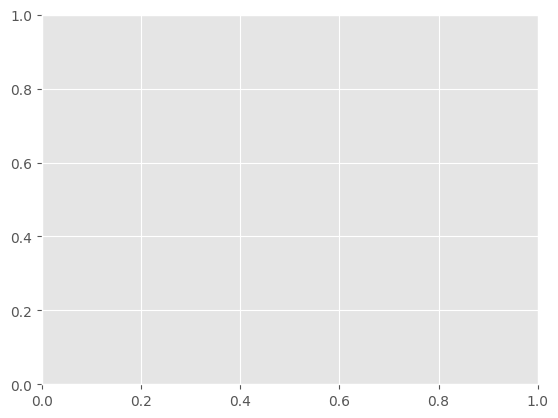

In [17]:
ax = plt.subplot(1,1,1)

### Step 7: Training, Testing and Validating

Here we are performing the main workload of ELMDA.

In [18]:
for i, (train_index, test_index) in enumerate(folded_dataset.split(X, y)):
    # Populating Train set
    X_train = X[train_index]
    y_train = y[train_index]

    # Populating Test set
    X_test = X[test_index]
    y_test = y[test_index]

    # Fitting the model into the training set
    ensemble_classifier.fit(X_train, y_train)

    # Predicting the values of the test set
    # Here the probability value means the probability of the sample being positive
    predict_value = ensemble_classifier.predict_proba(X_test)[:, 1]

    # Calculating the Area Under Curve value and appending it to the list
    _AUC = metrics.roc_auc_score(y_test, predict_value)
    auc_list.append(_AUC)

    # Calculating False Positive Rate, True Positive Rate and Threshold
    # Thresholds are the values that are used to determine whether a sample is positive or negative
    # Thresholds are not used in this code, but they are calculated here for completeness
    # After calculating the FPR and TPR, they are appended to the list
    _fpr, _tpr, _ignored_thresholds = roc_curve(y_test, predict_value)
    fpr.append(_fpr)
    tpr.append(_tpr)

    # Plotting the ROC curve
    #     ax.plot(
    #         fpr,
    #         tpr,
    #         lw=0.8,
    #         alpha=0.7,
    #         label=f"ROC Fold {i} (area={_AUC:.4f})"
    #     )
    # This was error: setting an array element with a sequence.
    
    # Plotting the ROC curve
    for _ in range(len(fpr)):
        ax.plot(
            fpr[i],
            tpr[i],
            lw=0.8,
            alpha=0.7,
            label=f"ROC Fold {i} (area={auc_list[i]:.4f})"
        )
        # END OF LOOP

    # Calculating the Area Under the Precision-Recall Curve value and appending it to the list
    # _ is ignored in this code.
    precision, recall, _ignored = precision_recall_curve(y_test, predict_value)
    _au_prc = auc(recall, precision)
    aupr_list.append(_au_prc)

    # Calculating Precision and appending it to the list
    _precision = precision_score(y_test, predict_value.round())
    precision_list.append(_precision)

    # Calculating Recall and appending it to the list
    _recall = recall_score(y_test, predict_value.round())
    recoil_list.append(_recall)

    # Calculating F1-score and appending it to the list
    _f1_score = f1_score(y_test, predict_value.round())
    f1_list.append(_f1_score)

    # END OF FOR LOOP

ax.axis(
    [0, 1, 0, 1.05]
)

ax.legend(
    loc='lower right',
    fontsize=12
)

axins = ax.inset_axes((0.2, 0.45, 0.4, 0.3))

for i in range(len(fpr)):
    axins.plot(
        fpr[i],
        tpr[i],
        lw = 0.8,
        alpha = 0.7
    )

axins.axis(
    [0.1, 0.35, 0.7, 0.9]
)

print("AUC: ", auc_list)
print("AUPR: ", aupr_list)
print("Precision: ", precision_list)
print("Recall: ", recoil_list)
print("F1: ", f1_list)

AUC:  [0.9224882325607867, 0.921606756922073, 0.9298702016017675, 0.9206576335284539, 0.9200772384614208]
AUPR:  [0.9199813702207394, 0.925057498881095, 0.9261053407103396, 0.9194827489232855, 0.9184336618017197]
Precision:  [0.8700564971751412, 0.8366606170598911, 0.8537258509659613, 0.8325832583258326, 0.8464317976513098]
Recall:  [0.846929422548121, 0.8412408759124088, 0.8713615023474178, 0.8509659613615456, 0.8588450962419798]
F1:  [0.8583372039015328, 0.8389444949954504, 0.8624535315985129, 0.8416742493175614, 0.8525932666060055]
